# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

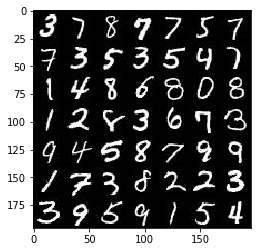

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

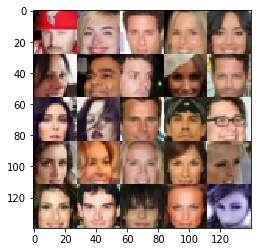

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/diptarkbose/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real=tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z=tf.placeholder(tf.float32, (None, z_dim))
    learning_rate=tf.placeholder(tf.float32,shape=None)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        #print(images.get_shape().as_list())
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2*x1, x1)
        drop1 = tf.nn.dropout(relu1, 0.9)
        #print(drop1.get_shape().as_list())
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2*bn2, bn2)
        drop2 = tf.nn.dropout(relu2, 0.9)

        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2*bn3, bn3)
        drop3 = tf.nn.dropout(relu3, 0.9)

        #print(drop3.get_shape().as_list())
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [43]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        #print(z.get_shape().as_list())
        x=tf.layers.dense(z, 7*7*256)
        x=tf.reshape(x, (-1, 7, 7, 256))
        x=tf.layers.batch_normalization(x, training=is_train)
        x=tf.maximum(0.2*x, x)
        x=tf.nn.dropout(x, 0.9)
        #print(x.get_shape().as_list())
        # First Layer
        x=tf.layers.conv2d_transpose(x, 128, 5, 2, 'same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        x=tf.layers.batch_normalization(x, training=is_train)
        x=tf.maximum(0.2*x, x)
        x=tf.nn.dropout(x, 0.9)
        #print(x.get_shape().as_list())
        
        x=tf.layers.conv2d_transpose(x, out_channel_dim, 5, 2, 'same', kernel_initializer= tf.contrib.layers.xavier_initializer())
        #print(x.get_shape())
        out=tf.tanh(x)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0 
    losses=[]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images=batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 12.1398... Generator Loss: 0.0022
Epoch 1/2... Discriminator Loss: 4.3827... Generator Loss: 0.1000
Epoch 1/2... Discriminator Loss: 6.1497... Generator Loss: 0.0145
Epoch 1/2... Discriminator Loss: 4.0293... Generator Loss: 0.0480
Epoch 1/2... Discriminator Loss: 3.7570... Generator Loss: 0.0638
Epoch 1/2... Discriminator Loss: 2.3671... Generator Loss: 0.1701
Epoch 1/2... Discriminator Loss: 2.1338... Generator Loss: 0.1820
Epoch 1/2... Discriminator Loss: 2.3379... Generator Loss: 0.1328
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 0.4197... Generator Loss: 2.8409


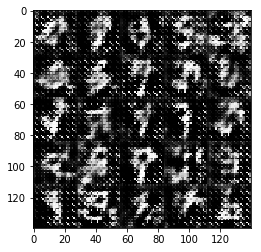

Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 2.8696
Epoch 1/2... Discriminator Loss: 0.5382... Generator Loss: 1.3751
Epoch 1/2... Discriminator Loss: 0.8623... Generator Loss: 2.2164
Epoch 1/2... Discriminator Loss: 2.4175... Generator Loss: 0.1328
Epoch 1/2... Discriminator Loss: 0.2820... Generator Loss: 3.2988
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 6.5396
Epoch 1/2... Discriminator Loss: 0.2143... Generator Loss: 2.4463
Epoch 1/2... Discriminator Loss: 0.2637... Generator Loss: 3.6043
Epoch 1/2... Discriminator Loss: 0.2761... Generator Loss: 7.6649
Epoch 1/2... Discriminator Loss: 2.0051... Generator Loss: 5.5248


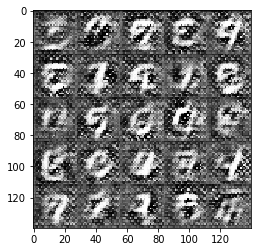

Epoch 1/2... Discriminator Loss: 3.6066... Generator Loss: 0.0565
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.4337
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 0.4190
Epoch 1/2... Discriminator Loss: 1.4688... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 0.6269
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.3241
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.4382


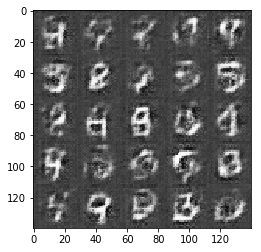

Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.4328
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.5429
Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.3779
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.4231
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.3888
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.4302
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.4651


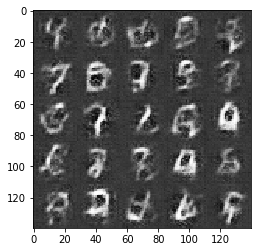

Epoch 1/2... Discriminator Loss: 1.3721... Generator Loss: 0.4148
Epoch 1/2... Discriminator Loss: 1.3157... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.3256... Generator Loss: 0.4065
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.4057
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 1.3071... Generator Loss: 0.4290
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.4429
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.4769


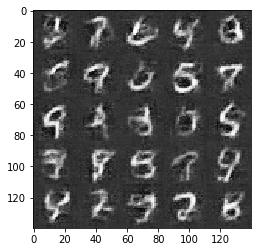

Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.4141
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 0.5658
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.3717
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.3128... Generator Loss: 0.4210
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 0.6087
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.4843
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 0.5533
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.3516
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 0.5646


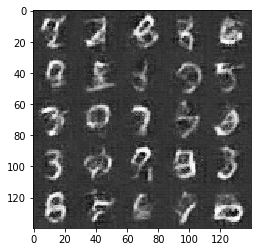

Epoch 2/2... Discriminator Loss: 1.4408... Generator Loss: 0.3721
Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 0.5384
Epoch 2/2... Discriminator Loss: 1.6052... Generator Loss: 0.3379
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.5587
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.3429
Epoch 2/2... Discriminator Loss: 1.2241... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 0.4395
Epoch 2/2... Discriminator Loss: 1.2627... Generator Loss: 0.4674


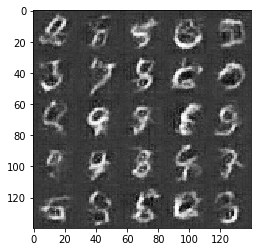

Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.3641
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 1.3124... Generator Loss: 0.4129
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.3741
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.5875... Generator Loss: 0.2942
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.3944
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.3925
Epoch 2/2... Discriminator Loss: 1.1763... Generator Loss: 0.5802
Epoch 2/2... Discriminator Loss: 1.4724... Generator Loss: 0.3387


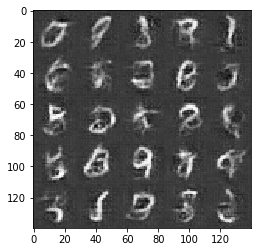

Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.3855
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.1307... Generator Loss: 0.5340
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 1.4876... Generator Loss: 0.3306
Epoch 2/2... Discriminator Loss: 1.4236... Generator Loss: 0.3724
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.3238
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.4031
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 0.5749


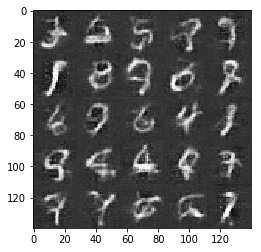

Epoch 2/2... Discriminator Loss: 1.5213... Generator Loss: 0.3346
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 1.5279... Generator Loss: 0.3476


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 1.7356... Generator Loss: 0.3543
Epoch 1/3... Discriminator Loss: 1.7882... Generator Loss: 1.0479
Epoch 1/3... Discriminator Loss: 7.2079... Generator Loss: 0.0022
Epoch 1/3... Discriminator Loss: 1.2091... Generator Loss: 4.0967
Epoch 1/3... Discriminator Loss: 0.3416... Generator Loss: 1.8520
Epoch 1/3... Discriminator Loss: 0.3520... Generator Loss: 1.9533
Epoch 1/3... Discriminator Loss: 0.3406... Generator Loss: 1.6374
Epoch 1/3... Discriminator Loss: 2.7331... Generator Loss: 0.2264
Epoch 1/3... Discriminator Loss: 1.2925... Generator Loss: 0.7248
Epoch 1/3... Discriminator Loss: 0.1963... Generator Loss: 2.8363


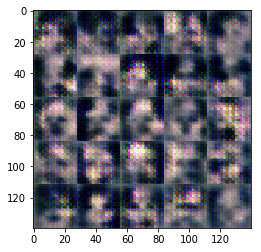

Epoch 1/3... Discriminator Loss: 3.5803... Generator Loss: 0.0592
Epoch 1/3... Discriminator Loss: 0.3482... Generator Loss: 3.5049
Epoch 1/3... Discriminator Loss: 0.0619... Generator Loss: 4.5266
Epoch 1/3... Discriminator Loss: 0.4918... Generator Loss: 1.7270
Epoch 1/3... Discriminator Loss: 0.9145... Generator Loss: 0.9524
Epoch 1/3... Discriminator Loss: 1.4431... Generator Loss: 0.5857
Epoch 1/3... Discriminator Loss: 1.0271... Generator Loss: 3.3477
Epoch 1/3... Discriminator Loss: 0.2688... Generator Loss: 2.8705
Epoch 1/3... Discriminator Loss: 0.4770... Generator Loss: 2.9583
Epoch 1/3... Discriminator Loss: 0.8389... Generator Loss: 0.8653


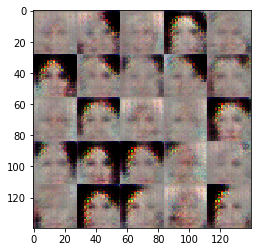

Epoch 1/3... Discriminator Loss: 0.8757... Generator Loss: 0.9660
Epoch 1/3... Discriminator Loss: 2.3371... Generator Loss: 0.1318
Epoch 1/3... Discriminator Loss: 0.4181... Generator Loss: 1.7830
Epoch 1/3... Discriminator Loss: 0.1218... Generator Loss: 5.7255
Epoch 1/3... Discriminator Loss: 0.2597... Generator Loss: 4.0853
Epoch 1/3... Discriminator Loss: 0.8409... Generator Loss: 0.9359
Epoch 1/3... Discriminator Loss: 0.5343... Generator Loss: 2.0377
Epoch 1/3... Discriminator Loss: 0.4021... Generator Loss: 1.9034
Epoch 1/3... Discriminator Loss: 0.6008... Generator Loss: 1.2884
Epoch 1/3... Discriminator Loss: 1.3749... Generator Loss: 0.4020


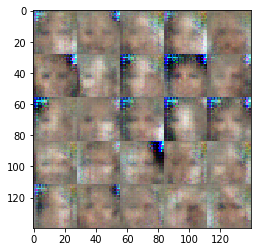

Epoch 1/3... Discriminator Loss: 0.5907... Generator Loss: 2.8304
Epoch 1/3... Discriminator Loss: 0.9547... Generator Loss: 0.9846
Epoch 1/3... Discriminator Loss: 0.6667... Generator Loss: 1.8563
Epoch 1/3... Discriminator Loss: 2.8250... Generator Loss: 5.0571
Epoch 1/3... Discriminator Loss: 1.4287... Generator Loss: 0.4348
Epoch 1/3... Discriminator Loss: 1.0479... Generator Loss: 0.6746
Epoch 1/3... Discriminator Loss: 0.7435... Generator Loss: 1.3067
Epoch 1/3... Discriminator Loss: 0.0771... Generator Loss: 4.3137
Epoch 1/3... Discriminator Loss: 0.7479... Generator Loss: 1.3108
Epoch 1/3... Discriminator Loss: 0.8209... Generator Loss: 0.8538


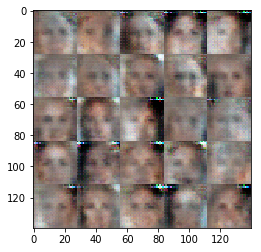

Epoch 1/3... Discriminator Loss: 1.0988... Generator Loss: 0.7963
Epoch 1/3... Discriminator Loss: 0.6002... Generator Loss: 1.3538
Epoch 1/3... Discriminator Loss: 3.1467... Generator Loss: 5.3517
Epoch 1/3... Discriminator Loss: 0.8210... Generator Loss: 3.5191
Epoch 1/3... Discriminator Loss: 1.0168... Generator Loss: 0.6401
Epoch 1/3... Discriminator Loss: 1.1710... Generator Loss: 0.6375
Epoch 1/3... Discriminator Loss: 0.4450... Generator Loss: 1.9951
Epoch 1/3... Discriminator Loss: 1.1064... Generator Loss: 0.7301
Epoch 1/3... Discriminator Loss: 0.5473... Generator Loss: 1.9071
Epoch 1/3... Discriminator Loss: 1.0168... Generator Loss: 0.8873


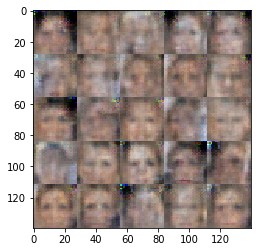

Epoch 1/3... Discriminator Loss: 2.1233... Generator Loss: 3.6525
Epoch 1/3... Discriminator Loss: 0.6845... Generator Loss: 1.7450
Epoch 1/3... Discriminator Loss: 0.7598... Generator Loss: 2.8501
Epoch 1/3... Discriminator Loss: 1.5556... Generator Loss: 0.4012
Epoch 1/3... Discriminator Loss: 0.5777... Generator Loss: 2.2029
Epoch 1/3... Discriminator Loss: 1.9734... Generator Loss: 2.6770
Epoch 1/3... Discriminator Loss: 2.4807... Generator Loss: 0.1260
Epoch 1/3... Discriminator Loss: 1.0090... Generator Loss: 1.2165
Epoch 1/3... Discriminator Loss: 1.3115... Generator Loss: 0.4414
Epoch 1/3... Discriminator Loss: 0.9940... Generator Loss: 1.5656


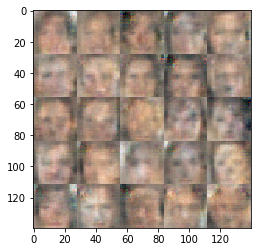

Epoch 1/3... Discriminator Loss: 2.0055... Generator Loss: 2.8861
Epoch 1/3... Discriminator Loss: 2.0258... Generator Loss: 0.2110
Epoch 1/3... Discriminator Loss: 2.0197... Generator Loss: 0.1968
Epoch 1/3... Discriminator Loss: 1.0104... Generator Loss: 1.6900
Epoch 1/3... Discriminator Loss: 1.1900... Generator Loss: 2.3600
Epoch 1/3... Discriminator Loss: 1.5838... Generator Loss: 0.4225
Epoch 1/3... Discriminator Loss: 1.3459... Generator Loss: 0.4836
Epoch 1/3... Discriminator Loss: 1.5696... Generator Loss: 0.3442
Epoch 1/3... Discriminator Loss: 1.4317... Generator Loss: 0.4154
Epoch 1/3... Discriminator Loss: 1.8069... Generator Loss: 1.6559


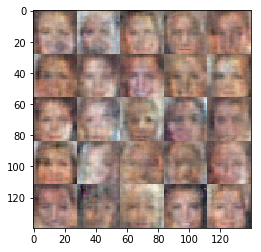

Epoch 1/3... Discriminator Loss: 1.1845... Generator Loss: 1.0343
Epoch 1/3... Discriminator Loss: 2.0755... Generator Loss: 0.1677
Epoch 1/3... Discriminator Loss: 1.8250... Generator Loss: 0.2513
Epoch 1/3... Discriminator Loss: 1.5437... Generator Loss: 0.3777
Epoch 1/3... Discriminator Loss: 1.3101... Generator Loss: 0.5598
Epoch 1/3... Discriminator Loss: 1.4474... Generator Loss: 0.5280
Epoch 1/3... Discriminator Loss: 1.4196... Generator Loss: 0.9954
Epoch 1/3... Discriminator Loss: 1.8961... Generator Loss: 0.2653
Epoch 1/3... Discriminator Loss: 1.9920... Generator Loss: 0.2243
Epoch 1/3... Discriminator Loss: 1.4546... Generator Loss: 0.3840


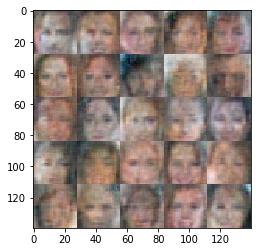

Epoch 1/3... Discriminator Loss: 1.1076... Generator Loss: 0.8611
Epoch 1/3... Discriminator Loss: 1.6561... Generator Loss: 0.3523
Epoch 1/3... Discriminator Loss: 1.4921... Generator Loss: 0.4593
Epoch 1/3... Discriminator Loss: 1.7515... Generator Loss: 1.5333
Epoch 1/3... Discriminator Loss: 1.2610... Generator Loss: 0.7165
Epoch 1/3... Discriminator Loss: 1.4260... Generator Loss: 0.5286
Epoch 1/3... Discriminator Loss: 1.4363... Generator Loss: 0.7393
Epoch 1/3... Discriminator Loss: 1.6529... Generator Loss: 0.3040
Epoch 1/3... Discriminator Loss: 1.4399... Generator Loss: 0.5892
Epoch 1/3... Discriminator Loss: 1.3498... Generator Loss: 0.7794


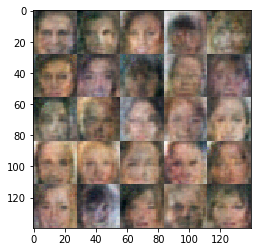

Epoch 1/3... Discriminator Loss: 1.3727... Generator Loss: 0.7046
Epoch 1/3... Discriminator Loss: 1.3159... Generator Loss: 0.5190
Epoch 1/3... Discriminator Loss: 1.5312... Generator Loss: 0.4134
Epoch 1/3... Discriminator Loss: 1.4893... Generator Loss: 0.5335
Epoch 1/3... Discriminator Loss: 1.4277... Generator Loss: 0.5699
Epoch 1/3... Discriminator Loss: 1.4341... Generator Loss: 0.4584
Epoch 1/3... Discriminator Loss: 1.3329... Generator Loss: 0.6961
Epoch 1/3... Discriminator Loss: 1.5248... Generator Loss: 1.0758
Epoch 1/3... Discriminator Loss: 1.4158... Generator Loss: 0.7977
Epoch 1/3... Discriminator Loss: 1.4303... Generator Loss: 0.7290


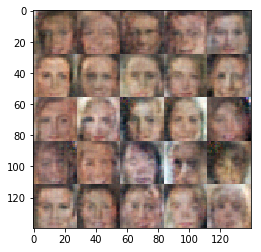

Epoch 1/3... Discriminator Loss: 1.4267... Generator Loss: 0.5686
Epoch 1/3... Discriminator Loss: 1.5628... Generator Loss: 0.4222
Epoch 1/3... Discriminator Loss: 1.5088... Generator Loss: 0.4624
Epoch 1/3... Discriminator Loss: 1.3496... Generator Loss: 0.6154
Epoch 1/3... Discriminator Loss: 1.3726... Generator Loss: 0.6080
Epoch 1/3... Discriminator Loss: 1.6663... Generator Loss: 1.2689
Epoch 1/3... Discriminator Loss: 1.3844... Generator Loss: 1.1130
Epoch 1/3... Discriminator Loss: 1.4099... Generator Loss: 0.9332
Epoch 1/3... Discriminator Loss: 1.6131... Generator Loss: 0.3515
Epoch 1/3... Discriminator Loss: 1.7918... Generator Loss: 0.2902


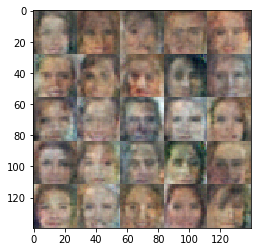

Epoch 1/3... Discriminator Loss: 1.3539... Generator Loss: 0.8225
Epoch 1/3... Discriminator Loss: 1.4683... Generator Loss: 0.6344
Epoch 1/3... Discriminator Loss: 1.2867... Generator Loss: 1.0326
Epoch 1/3... Discriminator Loss: 1.3216... Generator Loss: 0.6587
Epoch 1/3... Discriminator Loss: 1.3163... Generator Loss: 0.8036
Epoch 1/3... Discriminator Loss: 1.3973... Generator Loss: 0.5542
Epoch 1/3... Discriminator Loss: 1.3406... Generator Loss: 0.5340
Epoch 1/3... Discriminator Loss: 1.3724... Generator Loss: 0.6120
Epoch 1/3... Discriminator Loss: 1.3333... Generator Loss: 1.0167
Epoch 1/3... Discriminator Loss: 1.3105... Generator Loss: 0.6798


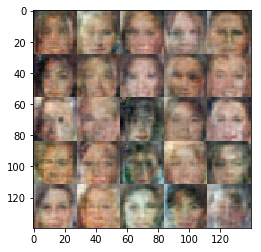

Epoch 1/3... Discriminator Loss: 1.4177... Generator Loss: 0.4626
Epoch 1/3... Discriminator Loss: 1.3916... Generator Loss: 0.4649
Epoch 1/3... Discriminator Loss: 1.2979... Generator Loss: 0.7794
Epoch 1/3... Discriminator Loss: 1.2885... Generator Loss: 0.9300
Epoch 1/3... Discriminator Loss: 1.3911... Generator Loss: 1.0039
Epoch 1/3... Discriminator Loss: 1.3271... Generator Loss: 0.9667
Epoch 1/3... Discriminator Loss: 1.4875... Generator Loss: 1.1839
Epoch 1/3... Discriminator Loss: 1.4559... Generator Loss: 0.9164
Epoch 1/3... Discriminator Loss: 1.0556... Generator Loss: 1.5150
Epoch 1/3... Discriminator Loss: 1.5118... Generator Loss: 1.1591


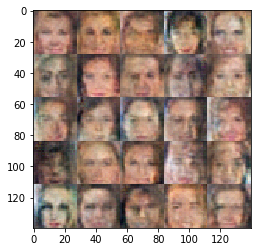

Epoch 1/3... Discriminator Loss: 2.5628... Generator Loss: 2.1851
Epoch 1/3... Discriminator Loss: 1.6757... Generator Loss: 0.3458
Epoch 1/3... Discriminator Loss: 0.9684... Generator Loss: 1.0755
Epoch 1/3... Discriminator Loss: 1.2741... Generator Loss: 0.9295
Epoch 1/3... Discriminator Loss: 1.2599... Generator Loss: 0.7168
Epoch 1/3... Discriminator Loss: 1.2757... Generator Loss: 0.8091
Epoch 1/3... Discriminator Loss: 1.6886... Generator Loss: 0.4021
Epoch 1/3... Discriminator Loss: 1.7911... Generator Loss: 1.6306
Epoch 1/3... Discriminator Loss: 1.4274... Generator Loss: 0.4888
Epoch 1/3... Discriminator Loss: 1.3233... Generator Loss: 0.7025


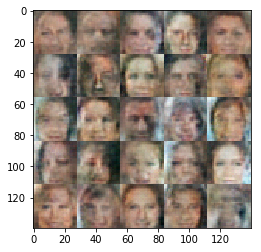

Epoch 1/3... Discriminator Loss: 1.3759... Generator Loss: 0.6336
Epoch 1/3... Discriminator Loss: 1.6788... Generator Loss: 0.8472
Epoch 1/3... Discriminator Loss: 1.4912... Generator Loss: 1.1799
Epoch 1/3... Discriminator Loss: 1.5008... Generator Loss: 0.4402
Epoch 1/3... Discriminator Loss: 1.2965... Generator Loss: 0.9128
Epoch 1/3... Discriminator Loss: 1.3017... Generator Loss: 0.5959
Epoch 1/3... Discriminator Loss: 1.3980... Generator Loss: 1.0234
Epoch 1/3... Discriminator Loss: 1.2333... Generator Loss: 0.6878
Epoch 1/3... Discriminator Loss: 1.3571... Generator Loss: 0.7851
Epoch 1/3... Discriminator Loss: 1.2435... Generator Loss: 1.0543


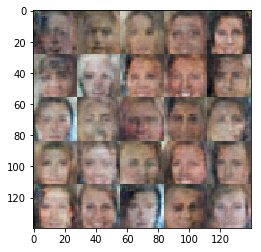

Epoch 1/3... Discriminator Loss: 1.2798... Generator Loss: 0.6416
Epoch 1/3... Discriminator Loss: 1.4182... Generator Loss: 0.5272
Epoch 1/3... Discriminator Loss: 1.3232... Generator Loss: 0.7037
Epoch 1/3... Discriminator Loss: 1.4724... Generator Loss: 0.3739
Epoch 1/3... Discriminator Loss: 2.1929... Generator Loss: 1.6836
Epoch 1/3... Discriminator Loss: 1.2849... Generator Loss: 0.6507
Epoch 1/3... Discriminator Loss: 1.3209... Generator Loss: 0.6464
Epoch 1/3... Discriminator Loss: 1.3722... Generator Loss: 0.4997
Epoch 2/3... Discriminator Loss: 1.3984... Generator Loss: 0.5727
Epoch 2/3... Discriminator Loss: 1.2574... Generator Loss: 0.8531


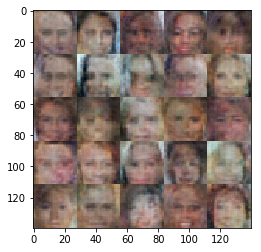

Epoch 2/3... Discriminator Loss: 1.4408... Generator Loss: 0.8619
Epoch 2/3... Discriminator Loss: 1.3380... Generator Loss: 0.5982
Epoch 2/3... Discriminator Loss: 1.2859... Generator Loss: 0.6930
Epoch 2/3... Discriminator Loss: 1.4084... Generator Loss: 1.0556
Epoch 2/3... Discriminator Loss: 1.4147... Generator Loss: 0.5526
Epoch 2/3... Discriminator Loss: 1.5357... Generator Loss: 1.2970
Epoch 2/3... Discriminator Loss: 1.2621... Generator Loss: 0.7203
Epoch 2/3... Discriminator Loss: 1.4396... Generator Loss: 0.4526
Epoch 2/3... Discriminator Loss: 1.3186... Generator Loss: 1.0591
Epoch 2/3... Discriminator Loss: 1.5460... Generator Loss: 0.4339


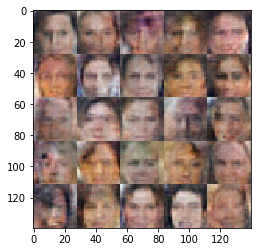

Epoch 2/3... Discriminator Loss: 1.3687... Generator Loss: 0.8084
Epoch 2/3... Discriminator Loss: 1.4870... Generator Loss: 1.2940
Epoch 2/3... Discriminator Loss: 1.5805... Generator Loss: 0.3107
Epoch 2/3... Discriminator Loss: 1.3796... Generator Loss: 0.5659
Epoch 2/3... Discriminator Loss: 1.4651... Generator Loss: 0.4621
Epoch 2/3... Discriminator Loss: 1.3362... Generator Loss: 0.6147
Epoch 2/3... Discriminator Loss: 1.3078... Generator Loss: 0.7303
Epoch 2/3... Discriminator Loss: 1.2628... Generator Loss: 1.2311
Epoch 2/3... Discriminator Loss: 1.2669... Generator Loss: 0.7750
Epoch 2/3... Discriminator Loss: 1.4088... Generator Loss: 1.1813


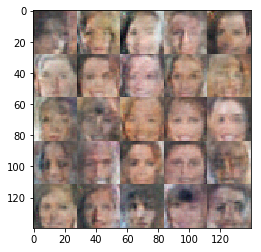

Epoch 2/3... Discriminator Loss: 1.3207... Generator Loss: 0.7148
Epoch 2/3... Discriminator Loss: 1.3509... Generator Loss: 0.6525
Epoch 2/3... Discriminator Loss: 1.4000... Generator Loss: 1.2104
Epoch 2/3... Discriminator Loss: 1.3514... Generator Loss: 0.8249
Epoch 2/3... Discriminator Loss: 1.3384... Generator Loss: 0.6503
Epoch 2/3... Discriminator Loss: 1.2853... Generator Loss: 0.7358
Epoch 2/3... Discriminator Loss: 1.3434... Generator Loss: 0.6635
Epoch 2/3... Discriminator Loss: 1.7967... Generator Loss: 1.2694
Epoch 2/3... Discriminator Loss: 1.2850... Generator Loss: 0.6538
Epoch 2/3... Discriminator Loss: 1.4570... Generator Loss: 0.8998


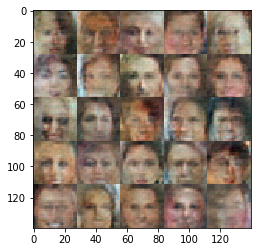

Epoch 2/3... Discriminator Loss: 1.6252... Generator Loss: 1.0204
Epoch 2/3... Discriminator Loss: 1.5552... Generator Loss: 0.9035
Epoch 2/3... Discriminator Loss: 1.5902... Generator Loss: 0.3697
Epoch 2/3... Discriminator Loss: 1.3722... Generator Loss: 0.4750
Epoch 2/3... Discriminator Loss: 1.5535... Generator Loss: 0.5901
Epoch 2/3... Discriminator Loss: 1.3063... Generator Loss: 0.5387
Epoch 2/3... Discriminator Loss: 1.4347... Generator Loss: 0.5829
Epoch 2/3... Discriminator Loss: 1.4490... Generator Loss: 0.8433
Epoch 2/3... Discriminator Loss: 1.4910... Generator Loss: 0.6396
Epoch 2/3... Discriminator Loss: 1.3508... Generator Loss: 0.5631


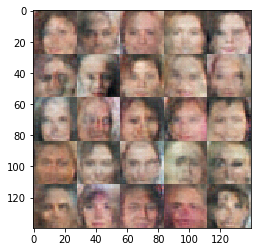

Epoch 2/3... Discriminator Loss: 1.4487... Generator Loss: 0.5035
Epoch 2/3... Discriminator Loss: 1.7253... Generator Loss: 0.5992
Epoch 2/3... Discriminator Loss: 1.4877... Generator Loss: 0.7926
Epoch 2/3... Discriminator Loss: 1.4306... Generator Loss: 0.8353
Epoch 2/3... Discriminator Loss: 1.3418... Generator Loss: 0.7768
Epoch 2/3... Discriminator Loss: 1.4528... Generator Loss: 0.9016
Epoch 2/3... Discriminator Loss: 1.3599... Generator Loss: 0.7080
Epoch 2/3... Discriminator Loss: 1.4252... Generator Loss: 0.4768
Epoch 2/3... Discriminator Loss: 1.3457... Generator Loss: 0.5583
Epoch 2/3... Discriminator Loss: 1.4009... Generator Loss: 0.6460


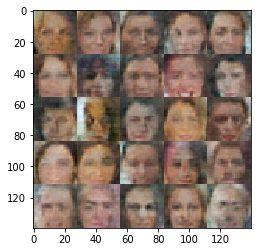

Epoch 2/3... Discriminator Loss: 1.3395... Generator Loss: 0.5864
Epoch 2/3... Discriminator Loss: 1.4168... Generator Loss: 0.4681
Epoch 2/3... Discriminator Loss: 1.3632... Generator Loss: 0.8983
Epoch 2/3... Discriminator Loss: 1.3782... Generator Loss: 0.8902
Epoch 2/3... Discriminator Loss: 1.6210... Generator Loss: 1.1814
Epoch 2/3... Discriminator Loss: 1.3583... Generator Loss: 1.0027
Epoch 2/3... Discriminator Loss: 1.3928... Generator Loss: 0.6798
Epoch 2/3... Discriminator Loss: 1.4703... Generator Loss: 0.4814
Epoch 2/3... Discriminator Loss: 1.4776... Generator Loss: 0.4558
Epoch 2/3... Discriminator Loss: 1.4300... Generator Loss: 0.5345


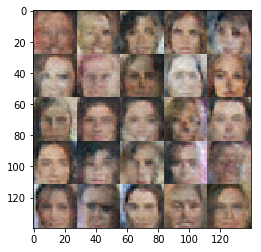

Epoch 2/3... Discriminator Loss: 1.4953... Generator Loss: 0.4385
Epoch 2/3... Discriminator Loss: 1.4114... Generator Loss: 0.4658
Epoch 2/3... Discriminator Loss: 1.5178... Generator Loss: 0.4650
Epoch 2/3... Discriminator Loss: 1.7672... Generator Loss: 0.2807
Epoch 2/3... Discriminator Loss: 1.6706... Generator Loss: 0.3835
Epoch 2/3... Discriminator Loss: 1.4868... Generator Loss: 0.5507
Epoch 2/3... Discriminator Loss: 1.4452... Generator Loss: 0.5119
Epoch 2/3... Discriminator Loss: 1.4960... Generator Loss: 0.4086
Epoch 2/3... Discriminator Loss: 1.4988... Generator Loss: 0.9315
Epoch 2/3... Discriminator Loss: 1.3779... Generator Loss: 0.5572


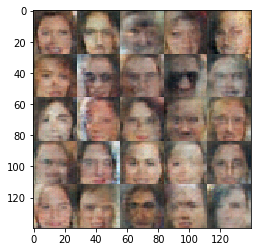

Epoch 2/3... Discriminator Loss: 1.4029... Generator Loss: 0.8611
Epoch 2/3... Discriminator Loss: 1.4948... Generator Loss: 0.5550
Epoch 2/3... Discriminator Loss: 1.4289... Generator Loss: 0.5188
Epoch 2/3... Discriminator Loss: 1.3957... Generator Loss: 0.5404
Epoch 2/3... Discriminator Loss: 1.4268... Generator Loss: 0.5868
Epoch 2/3... Discriminator Loss: 1.4475... Generator Loss: 0.7567
Epoch 2/3... Discriminator Loss: 1.3993... Generator Loss: 0.5659
Epoch 2/3... Discriminator Loss: 1.3329... Generator Loss: 0.7322
Epoch 2/3... Discriminator Loss: 1.4094... Generator Loss: 0.6221
Epoch 2/3... Discriminator Loss: 1.3722... Generator Loss: 0.8826


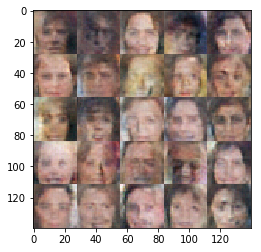

Epoch 2/3... Discriminator Loss: 1.4886... Generator Loss: 0.8665
Epoch 2/3... Discriminator Loss: 1.6584... Generator Loss: 1.1374
Epoch 2/3... Discriminator Loss: 1.5631... Generator Loss: 0.6342
Epoch 2/3... Discriminator Loss: 1.4499... Generator Loss: 0.7405
Epoch 2/3... Discriminator Loss: 1.4001... Generator Loss: 0.7577
Epoch 2/3... Discriminator Loss: 1.4611... Generator Loss: 1.0124
Epoch 2/3... Discriminator Loss: 1.3208... Generator Loss: 0.7154
Epoch 2/3... Discriminator Loss: 1.6289... Generator Loss: 0.3330
Epoch 2/3... Discriminator Loss: 1.3673... Generator Loss: 0.5680
Epoch 2/3... Discriminator Loss: 1.3758... Generator Loss: 0.5811


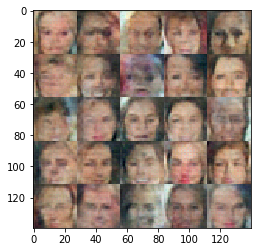

Epoch 2/3... Discriminator Loss: 1.2389... Generator Loss: 0.6000
Epoch 2/3... Discriminator Loss: 1.3339... Generator Loss: 0.9953
Epoch 2/3... Discriminator Loss: 1.3880... Generator Loss: 0.8259
Epoch 2/3... Discriminator Loss: 1.5747... Generator Loss: 0.3654
Epoch 2/3... Discriminator Loss: 1.2602... Generator Loss: 0.8995
Epoch 2/3... Discriminator Loss: 1.4288... Generator Loss: 0.6482
Epoch 2/3... Discriminator Loss: 1.4070... Generator Loss: 0.8579
Epoch 2/3... Discriminator Loss: 1.3638... Generator Loss: 0.6967
Epoch 2/3... Discriminator Loss: 1.4199... Generator Loss: 0.5755
Epoch 2/3... Discriminator Loss: 1.5787... Generator Loss: 0.3322


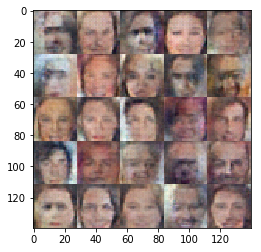

Epoch 2/3... Discriminator Loss: 1.5376... Generator Loss: 0.3917
Epoch 2/3... Discriminator Loss: 1.4157... Generator Loss: 0.5932
Epoch 2/3... Discriminator Loss: 1.4256... Generator Loss: 0.8420
Epoch 2/3... Discriminator Loss: 1.4543... Generator Loss: 0.5623
Epoch 2/3... Discriminator Loss: 1.3939... Generator Loss: 0.6215
Epoch 2/3... Discriminator Loss: 1.4702... Generator Loss: 0.4116
Epoch 2/3... Discriminator Loss: 1.6314... Generator Loss: 0.3421
Epoch 2/3... Discriminator Loss: 1.4470... Generator Loss: 0.7803
Epoch 2/3... Discriminator Loss: 1.6542... Generator Loss: 0.2948
Epoch 2/3... Discriminator Loss: 1.4763... Generator Loss: 1.1161


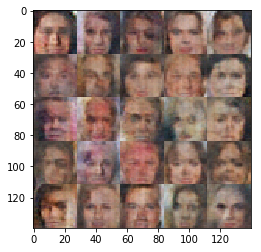

Epoch 2/3... Discriminator Loss: 1.6109... Generator Loss: 0.6641
Epoch 2/3... Discriminator Loss: 1.4463... Generator Loss: 0.8251
Epoch 2/3... Discriminator Loss: 1.5079... Generator Loss: 1.2344
Epoch 2/3... Discriminator Loss: 1.3223... Generator Loss: 0.7276
Epoch 2/3... Discriminator Loss: 1.3811... Generator Loss: 0.6165
Epoch 2/3... Discriminator Loss: 1.3891... Generator Loss: 0.6590
Epoch 2/3... Discriminator Loss: 1.3383... Generator Loss: 0.5372
Epoch 2/3... Discriminator Loss: 1.4563... Generator Loss: 0.5413
Epoch 2/3... Discriminator Loss: 1.6420... Generator Loss: 0.3128
Epoch 2/3... Discriminator Loss: 1.4196... Generator Loss: 0.5110


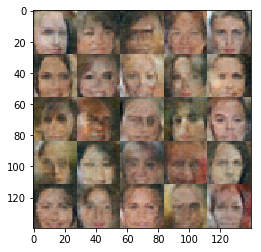

Epoch 2/3... Discriminator Loss: 1.4536... Generator Loss: 0.8744
Epoch 2/3... Discriminator Loss: 1.3506... Generator Loss: 0.7441
Epoch 2/3... Discriminator Loss: 1.5469... Generator Loss: 0.6401
Epoch 2/3... Discriminator Loss: 1.4358... Generator Loss: 0.9772
Epoch 2/3... Discriminator Loss: 1.3530... Generator Loss: 0.9809
Epoch 2/3... Discriminator Loss: 1.3457... Generator Loss: 0.6550
Epoch 2/3... Discriminator Loss: 1.3404... Generator Loss: 0.7816
Epoch 2/3... Discriminator Loss: 1.6578... Generator Loss: 0.4605
Epoch 2/3... Discriminator Loss: 1.4311... Generator Loss: 0.5480
Epoch 2/3... Discriminator Loss: 1.3635... Generator Loss: 0.8382


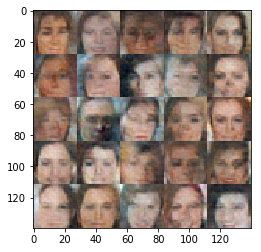

Epoch 2/3... Discriminator Loss: 1.4315... Generator Loss: 0.6958
Epoch 2/3... Discriminator Loss: 1.4943... Generator Loss: 0.4570
Epoch 2/3... Discriminator Loss: 1.4416... Generator Loss: 0.6993
Epoch 2/3... Discriminator Loss: 1.3297... Generator Loss: 0.6601
Epoch 2/3... Discriminator Loss: 1.3729... Generator Loss: 0.6282
Epoch 2/3... Discriminator Loss: 1.3460... Generator Loss: 0.5982
Epoch 2/3... Discriminator Loss: 1.3650... Generator Loss: 0.7223
Epoch 2/3... Discriminator Loss: 1.4654... Generator Loss: 0.8545
Epoch 2/3... Discriminator Loss: 1.4348... Generator Loss: 0.7765


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.